In [ ]:
# O artigo "A time series forecasting method for oil production based on Informer optimized by Bayesian optimization and the hyperband algorithm (BOHB)"
# Foi usado como referência para configurar o conjunto de treino, teste, preprocessamento e sliding-window

# Treino: 85%
# Teste: 15%
# Preprocessamento: StandardScaler
# Sliding-Window: input_size=6, horizon=1

In [60]:
!pip install feature-engine
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [264]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from feature_engine.wrappers import SklearnTransformerWrapper
from neuralforecast import NeuralForecast
from neuralforecast.models import MLPMultivariate
from time import time
import math
from tqdm import tqdm
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [117]:
ROOT = "/content/drive/MyDrive/dl-project"
DATA_FILE = f"{ROOT}/data/multivariate/volve-production-data.csv"

DATE = ['DATEPRD']
TIMESERIES = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
SEED = 78

horizon = 1
input_size = 6

In [118]:
data = pd.read_csv(DATA_FILE)

In [119]:
data.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


### Preprocessing

In [120]:
# Selecionar os dados do poço NO15/9-F-12H que possui a série mais longa
timeseries_data = data.loc[
    data["WELL_BORE_CODE"] == "NO 15/9-F-12 H",
     ["DATEPRD", "BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]
].copy()

In [121]:
timeseries_data.head()

,DATEPRD,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
1911,2008-02-12,284.65,38888.67,385.01
1912,2008-02-13,1869.70,285246.16,7.13
1913,2008-02-14,3124.09,509954.88,1.16
1914,2008-02-15,2608.28,383426.67,0.97
1915,2008-02-16,3051.80,418474.00,4.89


In [122]:
timeseries_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3056 entries, 1911 to 4966
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATEPRD       3056 non-null   object 
 1   BORE_OIL_VOL  3056 non-null   float64
 2   BORE_GAS_VOL  3056 non-null   float64
 3   BORE_WAT_VOL  3056 non-null   float64
dtypes: float64(3), object(1)
memory usage: 183.9+ KB


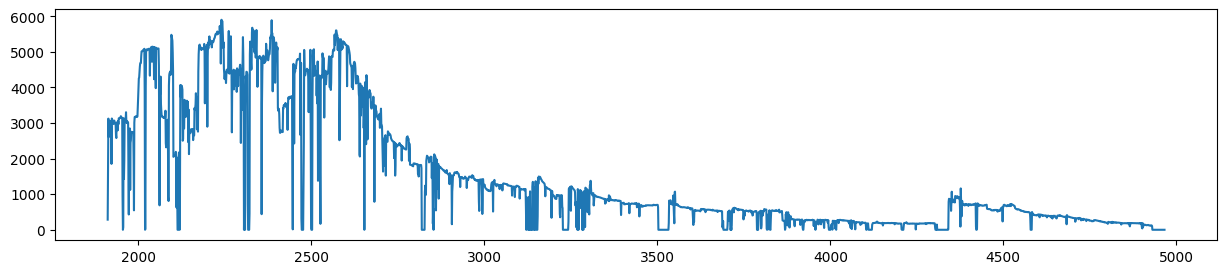

In [123]:
timeseries_data['BORE_OIL_VOL'].plot(figsize=(15, 3));

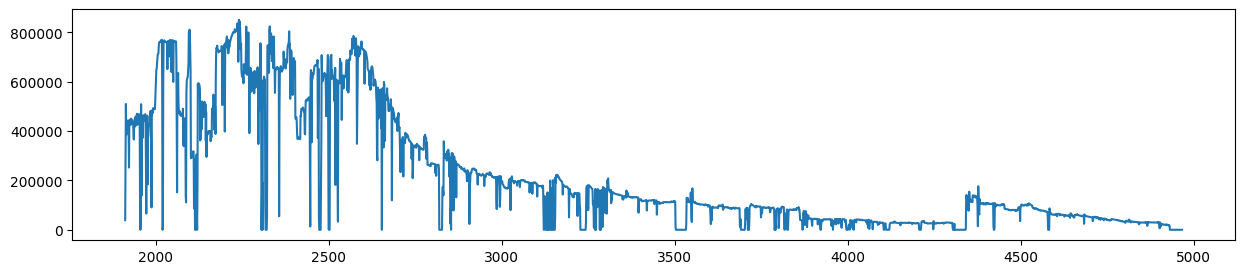

In [124]:
timeseries_data['BORE_GAS_VOL'].plot(figsize=(15, 3));

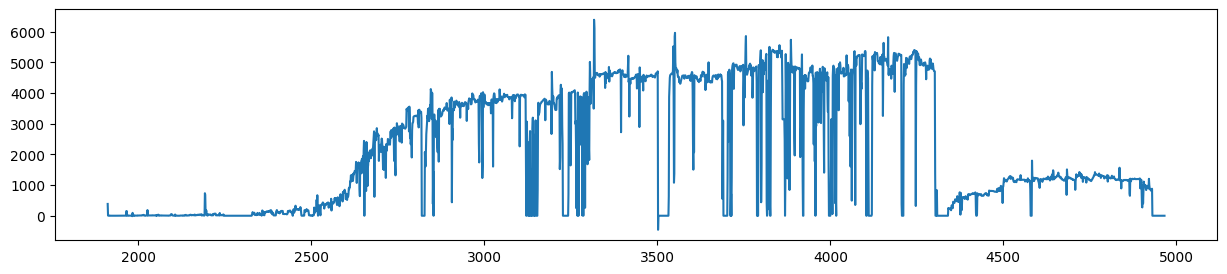

In [125]:
timeseries_data['BORE_WAT_VOL'].plot(figsize=(15, 3));

In [46]:
# Separaçao entre treino e teste
train_size = int(len(timeseries_data) * 0.85)
train_data = timeseries_data.iloc[:train_size]
test_data = timeseries_data.iloc[train_size:]

train_data.shape, test_data.shape

((2597, 4), (459, 4))

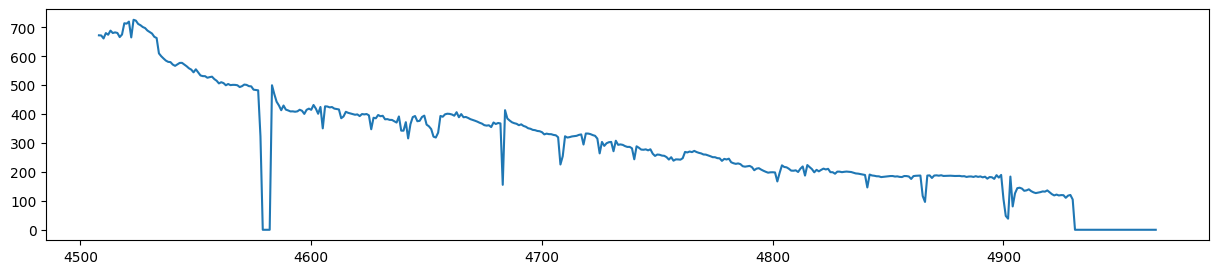

In [50]:
test_data['BORE_OIL_VOL'].plot(figsize=(15, 3));

In [56]:
scaler = SklearnTransformerWrapper(StandardScaler(), variables=TIMESERIES)
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [69]:
# Preparaçao dos dados para usar o Nixtla

train_timeseries = train_scaled.rename(columns={'DATEPRD': 'ds'})
train_timeseries['ds'] = pd.to_datetime(train_timeseries['ds'])

train_timeseries_long = train_timeseries.melt(
    id_vars='ds',
    value_vars=['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'],
    var_name='unique_id',
    value_name='y'
)

train_timeseries_long

,ds,unique_id,y
0,2008-02-12,BORE_OIL_VOL,-0.830648
1,2008-02-13,BORE_OIL_VOL,0.092565
2,2008-02-14,BORE_OIL_VOL,0.823185
3,2008-02-15,BORE_OIL_VOL,0.522752
4,2008-02-16,BORE_OIL_VOL,0.781080
...,...,...,...
7786,2015-06-12,BORE_WAT_VOL,-0.639981
7787,2015-06-13,BORE_WAT_VOL,-0.644288
7788,2015-06-14,BORE_WAT_VOL,-0.616490
7789,2015-06-15,BORE_WAT_VOL,-0.630882


### MLPMultivariate

In [76]:
models=[
    MLPMultivariate(
        n_series=3,
        h=horizon,
        input_size=input_size,
        max_steps=500,
        random_seed=SEED
    )
]



INFO:lightning_fabric.utilities.seed:Seed set to 78


#### Training

In [77]:
nf = NeuralForecast(
    models=models,
    freq='D'
)

nf.fit(df=train_timeseries_long, val_size=horizon)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 3.1 K  | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.289     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [78]:
def nixtla_format_df(data):
    data = data.rename(columns={'DATEPRD': 'ds'})
    data['ds'] = pd.to_datetime(data['ds'])
    data = data.melt(
        id_vars='ds',
        value_vars=['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'],
        var_name='unique_id',
        value_name='y'
    )

    return data

#### Predictions

In [115]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train_scaled.tail(input_size), test_scaled])

In [148]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
from time import time

forecasts_list = []
start_time = time()

for input_df in inputs_for_predicions_list:
    input_df = nixtla_format_df(input_df)
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

multivariate_inference_time = time() - start_time
print("Inference time:", round(multivariate_inference_time))

In [158]:
forecasts_output = pd.concat(forecasts_list)
forecasts_output

,unique_id,ds,MLPMultivariate
0,BORE_GAS_VOL,2015-06-17,-0.578915
1,BORE_OIL_VOL,2015-06-17,-0.591607
2,BORE_WAT_VOL,2015-06-17,-0.590409
0,BORE_GAS_VOL,2015-06-18,-0.578369
1,BORE_OIL_VOL,2015-06-18,-0.592267
...,...,...,...
1,BORE_OIL_VOL,2016-09-17,-0.961761
2,BORE_WAT_VOL,2016-09-17,-1.088076
0,BORE_GAS_VOL,2016-09-18,-0.938671
1,BORE_OIL_VOL,2016-09-18,-0.961761


In [186]:
ground_truth = nixtla_format_df(test_scaled)
ground_truth

,ds,unique_id,y
0,2015-06-17,BORE_OIL_VOL,-0.604704
1,2015-06-18,BORE_OIL_VOL,-0.604984
2,2015-06-19,BORE_OIL_VOL,-0.611041
3,2015-06-20,BORE_OIL_VOL,-0.600196
4,2015-06-21,BORE_OIL_VOL,-0.603545
...,...,...,...
1372,2016-09-13,BORE_WAT_VOL,-1.192612
1373,2016-09-14,BORE_WAT_VOL,-1.192612
1374,2016-09-15,BORE_WAT_VOL,-1.192612
1375,2016-09-16,BORE_WAT_VOL,-1.192612


In [187]:
mlpmultivariate_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='inner'
)
mlpmultivariate_results

,ds,unique_id,y,MLPMultivariate
0,2015-06-17,BORE_OIL_VOL,-0.604704,-0.591607
1,2015-06-18,BORE_OIL_VOL,-0.604984,-0.592267
2,2015-06-19,BORE_OIL_VOL,-0.611041,-0.594562
3,2015-06-20,BORE_OIL_VOL,-0.600196,-0.598377
4,2015-06-21,BORE_OIL_VOL,-0.603545,-0.590927
...,...,...,...,...
1372,2016-09-13,BORE_WAT_VOL,-1.192612,-1.088076
1373,2016-09-14,BORE_WAT_VOL,-1.192612,-1.088076
1374,2016-09-15,BORE_WAT_VOL,-1.192612,-1.088076
1375,2016-09-16,BORE_WAT_VOL,-1.192612,-1.088076


In [197]:
# Salvar Resultados
mlpmultivariate_results.to_csv(f"{ROOT}/results/MLP_Multivariate.csv", index=False)

In [226]:
# Retornar para os valores originais.

scaled_test_data_wide = (
    mlpmultivariate_results
    .pivot(index='ds',
           columns='unique_id',
           values='y')
    .reset_index()
    .rename_axis(None, axis=1)
)

scaled_predicted_data_wide = (
    mlpmultivariate_results
    .pivot(index='ds',
           columns='unique_id',
           values='MLPMultivariate')
    .reset_index()
    .rename_axis(None, axis=1)
)


In [240]:
original_test_data = scaler.inverse_transform(scaled_test_data_wide)
original_predicted_data = scaler.inverse_transform(scaled_predicted_data_wide)

In [ ]:
(
    original_predicted_data
    .rename(
        columns={col: f'pred_{col}' for col in original_predicted_data.columns[1:]},
        inplace=True
    )
)

In [243]:
original_scale_results = pd.merge(
    original_test_data,
    original_predicted_data,
    on='ds',
    how='inner'
)
original_scale_results

,ds,BORE_GAS_VOL,BORE_OIL_VOL,BORE_WAT_VOL,pred_BORE_GAS_VOL,pred_BORE_OIL_VOL,pred_BORE_WAT_VOL
0,2015-06-17,9.835613e+04,672.57,1169.20,108550.929688,695.056458,1228.955688
1,2015-06-18,9.777656e+04,672.09,1146.60,108683.367188,693.923218,1234.765015
2,2015-06-19,9.820446e+04,661.69,1117.33,107655.773438,689.982300,1223.758545
3,2015-06-20,1.006595e+05,680.31,1151.62,107530.992188,683.433533,1204.358765
4,2015-06-21,1.004866e+05,674.56,1177.07,109908.195312,696.223267,1223.835693
...,...,...,...,...,...,...,...
454,2016-09-13,-2.910383e-11,0.00,0.00,21314.615234,59.545700,213.332962
455,2016-09-14,-2.910383e-11,0.00,0.00,21314.615234,59.545700,213.332962
456,2016-09-15,-2.910383e-11,0.00,0.00,21314.615234,59.545700,213.332962
457,2016-09-16,-2.910383e-11,0.00,0.00,21314.615234,59.545700,213.332962


In [244]:
y_pred_oil = original_scale_results['pred_BORE_OIL_VOL']
y_pred_gas = original_scale_results['pred_BORE_GAS_VOL']
y_pred_wat = original_scale_results['pred_BORE_WAT_VOL']

y_true_oil = original_scale_results['BORE_OIL_VOL']
y_true_gas = original_scale_results['BORE_GAS_VOL']
y_true_wat = original_scale_results['BORE_WAT_VOL']

In [256]:
print("=" * 50)
print("         MLPMultivariate Performance")
print("=" * 50)

# RMSE Section
print("\n📊 Root Mean Square Error (RMSE)")
print("-" * 35)
print(f"  Oil   : {math.sqrt(mean_squared_error(y_true_oil, y_pred_oil)):.4f}")
print(f"  Gas   : {math.sqrt(mean_squared_error(y_true_gas, y_pred_gas)):.4f}")
print(f"  Water : {math.sqrt(mean_squared_error(y_true_wat, y_pred_wat)):.4f}")

# R² Section
print("\n🎯 R-squared (R²)")
print("-" * 20)
print(f"  Oil   : {r2_score(y_true_oil, y_pred_oil):.4f}")
print(f"  Gas   : {r2_score(y_true_gas, y_pred_gas):.4f}")
print(f"  Water : {r2_score(y_true_wat, y_pred_wat):.4f}")

# MAE Section
print("\n📈 Mean Absolute Error (MAE)")
print("-" * 32)
print(f"  Oil   : {mean_absolute_error(y_true_oil, y_pred_oil):.4f}")
print(f"  Gas   : {mean_absolute_error(y_true_gas, y_pred_gas):.4f}")
print(f"  Water : {mean_absolute_error(y_true_wat, y_pred_wat):.4f}")

print("=" * 50)

         MLPMultivariate Performance

📊 Root Mean Square Error (RMSE)
-----------------------------------
  Oil   : 60.0083
  Gas   : 17787.3784
  Water : 160.8560

🎯 R-squared (R²)
--------------------
  Oil   : 0.8774
  Gas   : 0.5015
  Water : 0.8006

📈 Mean Absolute Error (MAE)
--------------------------------
  Oil   : 47.9805
  Gas   : 16817.3962
  Water : 89.6915


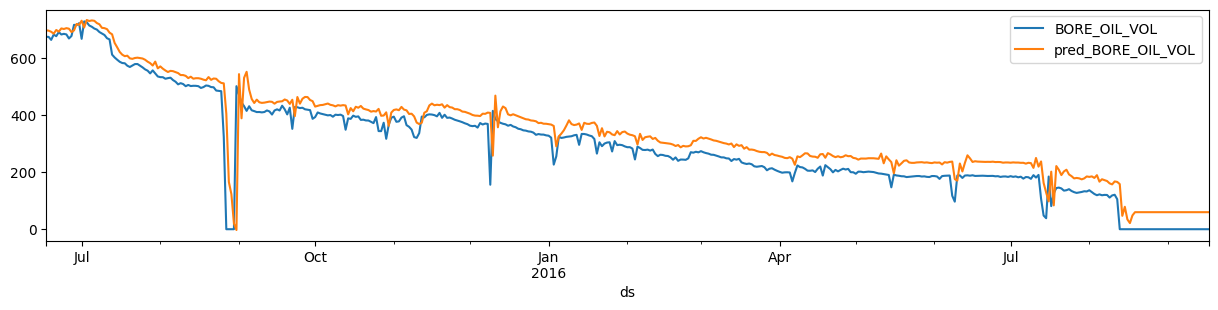

In [248]:
# OIL

  (
    original_scale_results
    .plot(x='ds', y=['BORE_OIL_VOL', 'pred_BORE_OIL_VOL'], figsize=(15, 3))
);

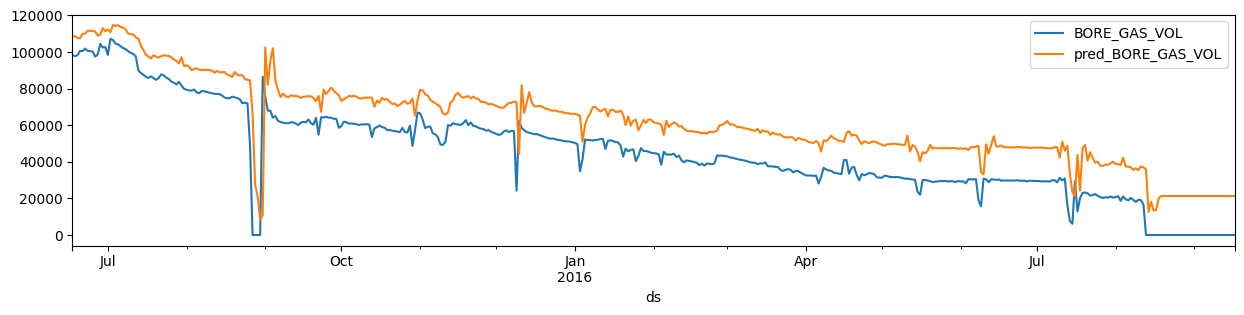

In [249]:
# GAS

(
    original_scale_results
    .plot(x='ds', y=['BORE_GAS_VOL', 'pred_BORE_GAS_VOL'], figsize=(15, 3))
);

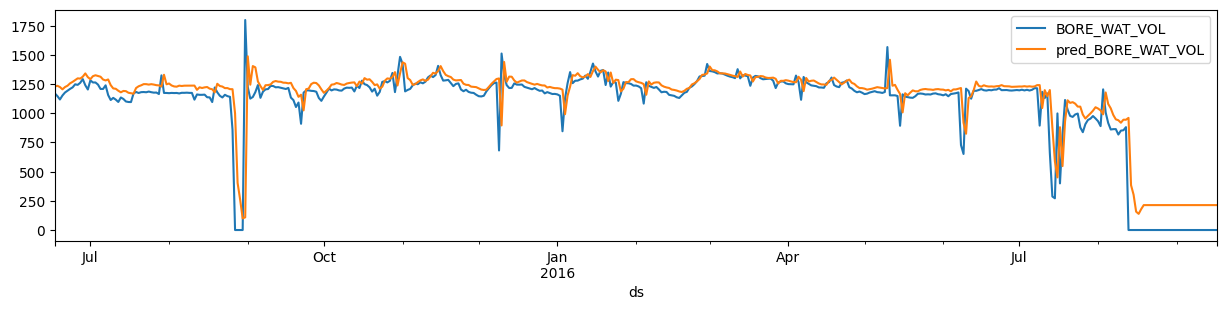

In [250]:
# WATER

(
    original_scale_results
    .plot(x='ds', y=['BORE_WAT_VOL', 'pred_BORE_WAT_VOL'], figsize=(15, 3))
);